<a href="https://colab.research.google.com/github/bkvkrll/Machine-Learning-in-Business/blob/main/lesson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd

In [7]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [8]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [9]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [10]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 6.9 MB/s 


In [11]:
pip install razdel

In [12]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2  

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [15]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

151

In [16]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [17]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 24.8 s, sys: 1.57 s, total: 26.4 s
Wall time: 26.4 s


In [18]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 12s, sys: 395 ms, total: 3min 12s
Wall time: 3min 12s


In [19]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [20]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [21]:
from gensim.models import LdaModel

In [22]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 57.8 s, sys: 28.6 s, total: 1min 26s
Wall time: 55 s


In [23]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [24]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(10, 0.10115489),
 (12, 0.048717473),
 (13, 0.29161397),
 (15, 0.2536715),
 (20, 0.1926651),
 (21, 0.05559649),
 (22, 0.04158054)]

In [25]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: животное год турция учёный турецкий nn птица
topic_1: район остров море строительство вода аэропорт год
topic_2: спутник земля сша это телескоп вицепремьер запустить
topic_3: учёный женщина журнал мужчина исследование год автор
topic_4: который nn россия президент год российский это
topic_5: ракета украина украинский киев восток дональд земля
topic_6: луна год станция фестиваль век город древний
topic_7: год статья nn русский который памятник ребёнок
topic_8: активность граница расчёт °с землетрясение зонд операция
topic_9: год компания млн это экономика исследование руб
topic_10: год болезнь страдать вирус затмение климат это
topic_11: россия газ это российский сша государство сторона
topic_12: это который год свой человек научный военный
topic_13: это мочь который всё выяснить весь операция
topic_14: фонд сколково nn иран геном выдавать конференция
topic_15: космический планета земля космос писать это орбита
topic_16: самолёт погибнуть полёт двигатель статья пассажир писать


In [26]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [27]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.154257,0.0,0.0,0.0,0.0,0.00000,0.000000,0.657523,0.000000,0.010920,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.143092,0.000000,0.000000,0.027757,0.0
1,4896,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0.543078,0.0,0.400912,0.000000,0.000000,0.035545,0.0
2,4897,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.100895,0.000000,0.048778,0.291784,0.0000,0.253608,0.0,0.0,0.000000,0.0,0.192949,0.055551,0.041436,0.000000,0.0
3,4898,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.558411,0.113393,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.318308,0.000000,0.000000,0.000000,0.0
4,4899,0.0,0.0,0.0,0.0,0.160672,0.0,0.0,0.0,0.0,0.06223,0.000000,0.112785,0.000000,0.000000,0.5714,0.000000,0.0,0.0,0.000000,0.0,0.072400,0.000000,0.000000,0.000000,0.0


In [28]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [29]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [30]:
doc_dict[293622]

array([0.02734881, 0.        , 0.06174246, 0.1158995 , 0.11176099,
       0.        , 0.        , 0.18672973, 0.14627707, 0.        ,
       0.02069918, 0.04177701, 0.        , 0.        , 0.0122835 ,
       0.        , 0.        , 0.        , 0.0566465 , 0.        ,
       0.05584277, 0.09457266, 0.06366736, 0.        , 0.        ])

In [31]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [32]:
get_user_embedding(user_articles_list)

array([0.03614254, 0.01931095, 0.06721396, 0.        , 0.25377484,
       0.02715246, 0.00772873, 0.04255981, 0.0018654 , 0.00956727,
       0.        , 0.11912496, 0.14024412, 0.0303325 , 0.        ,
       0.00192739, 0.01440339, 0.01387305, 0.10037465, 0.03878653,
       0.        , 0.00950634, 0.01164414, 0.0467715 , 0.        ])

In [33]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.012892,0.000000,0.010290,0.055104,0.084430,0.096902,0.075392,0.115580,0.048006,0.014433,0.006883,0.006963,0.049325,0.008386,0.050278,0.011825,0.012557,0.065965,0.133008,0.055815,0.025280,0.015762,0.014977,0.016716,0.000000
1,u108690,0.001987,0.044761,0.019923,0.009947,0.181719,0.052607,0.010679,0.034814,0.001782,0.035103,0.026518,0.128720,0.079082,0.087624,0.000000,0.001744,0.007567,0.027384,0.110498,0.040318,0.000000,0.008493,0.026496,0.045278,0.002433
2,u108339,0.051160,0.019781,0.000000,0.002069,0.247373,0.003129,0.039655,0.017996,0.021077,0.006873,0.004331,0.058748,0.048542,0.029291,0.006620,0.006389,0.059030,0.052262,0.205624,0.030317,0.007261,0.005223,0.016007,0.045863,0.000000


In [34]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [35]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.012892,0.000000,0.010290,0.055104,0.084430,0.096902,0.075392,0.115580,0.048006,0.014433,0.006883,0.006963,0.049325,0.008386,0.050278,0.011825,0.012557,0.065965,0.133008,0.055815,0.025280,0.015762,0.014977,0.016716,0.000000,0
1,u108690,0.001987,0.044761,0.019923,0.009947,0.181719,0.052607,0.010679,0.034814,0.001782,0.035103,0.026518,0.128720,0.079082,0.087624,0.000000,0.001744,0.007567,0.027384,0.110498,0.040318,0.000000,0.008493,0.026496,0.045278,0.002433,1
2,u108339,0.051160,0.019781,0.000000,0.002069,0.247373,0.003129,0.039655,0.017996,0.021077,0.006873,0.004331,0.058748,0.048542,0.029291,0.006620,0.006389,0.059030,0.052262,0.205624,0.030317,0.007261,0.005223,0.016007,0.045863,0.000000,1


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [38]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [39]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.30629678, 0.03339121, 0.36244954, 0.22287635, 0.09160394,
       0.01751077, 0.11230397, 0.07086529, 0.05247252, 0.07362763])

In [40]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [41]:
import itertools

In [42]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.259749, F-Score=0.674, Precision=0.629, Recall=0.727


In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1650  105]
 [  68  177]]


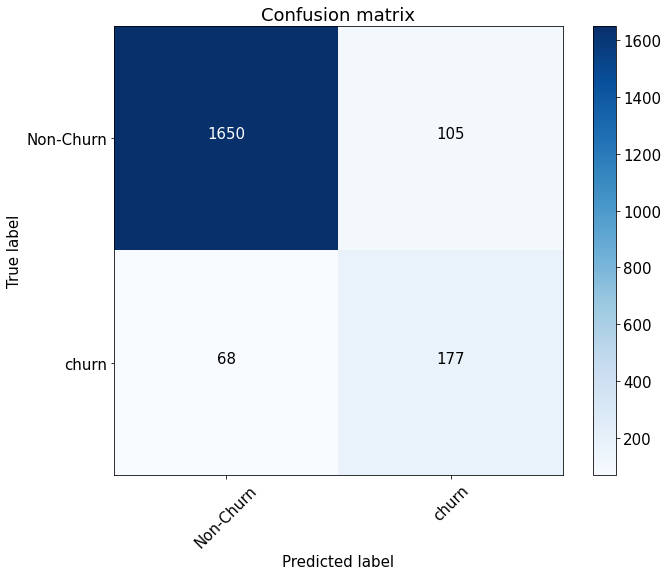

In [44]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [45]:
roc_auc_score(y_test, preds)

0.9434827606256178

Самостоятельно разобраться с тем, что такое tfidf

In [62]:
import collections

def compute_tf(text):
    tf_text = collections.Counter(text)
    for i in tf_text:
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text



compute_tf(news)

Counter({'doc_id': 3.7037037037037037e-05, 'title': 3.7037037037037037e-05})

In [64]:
import math

def compute_idf(word, corpus):
    return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

compute_idf('title', news)


4.431363764158987

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)


In [47]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [48]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.000000,0.0,0.055880,0.016384,0.033702,0.149417,0.04123,0.0,0.000000,0.000000,0.020357,0.000000,0.006142,0.0,0.000000,0.019297,0.102973,0.018821,0.022122,0.0,0.000000,0.000000,0.0
1,u108690,0.0,0.007709,0.012657,0.0,0.166716,0.040299,0.000000,0.017401,0.00000,0.0,0.006404,0.067087,0.026844,0.071845,0.000000,0.0,0.000000,0.000000,0.054494,0.020727,0.000000,0.0,0.015931,0.054614,0.0
2,u108339,0.0,0.015112,0.000000,0.0,0.281480,0.000000,0.036851,0.017896,0.00000,0.0,0.000000,0.044352,0.033228,0.037039,0.000000,0.0,0.005729,0.033908,0.186580,0.008732,0.000000,0.0,0.005600,0.030118,0.0


In [49]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [50]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.000000,0.0,0.055880,0.016384,0.033702,0.149417,0.04123,0.0,0.000000,0.000000,0.020357,0.000000,0.006142,0.0,0.000000,0.019297,0.102973,0.018821,0.022122,0.0,0.000000,0.000000,0.0,0
1,u108690,0.0,0.007709,0.012657,0.0,0.166716,0.040299,0.000000,0.017401,0.00000,0.0,0.006404,0.067087,0.026844,0.071845,0.000000,0.0,0.000000,0.000000,0.054494,0.020727,0.000000,0.0,0.015931,0.054614,0.0,1
2,u108339,0.0,0.015112,0.000000,0.0,0.281480,0.000000,0.036851,0.017896,0.00000,0.0,0.000000,0.044352,0.033228,0.037039,0.000000,0.0,0.005729,0.033908,0.186580,0.008732,0.000000,0.0,0.005600,0.030118,0.0,1


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [52]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.259749, F-Score=0.674, Precision=0.629, Recall=0.727


Повторить п.2, но используя уже не медиану, а max

In [54]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [55]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.050005,0.000000,0.061742,0.214725,0.249769,0.430049,0.289665,0.190438,0.146277,0.086600,0.020699,0.041777,0.163926,0.050314,0.246953,0.070952,0.044029,0.308821,0.349399,0.205085,0.055843,0.094573,0.063667,0.100299,0.000000
1,u108690,0.011924,0.237481,0.050127,0.040003,0.257400,0.148259,0.064071,0.107378,0.010690,0.171506,0.128916,0.492822,0.240992,0.159616,0.000000,0.010461,0.045399,0.114192,0.439521,0.137263,0.000000,0.029814,0.103098,0.087826,0.014596
2,u108339,0.154869,0.051027,0.000000,0.012412,0.410109,0.018772,0.111699,0.042673,0.067704,0.030635,0.025985,0.132225,0.152339,0.047719,0.028328,0.020224,0.192588,0.157296,0.347038,0.105863,0.026650,0.021062,0.058373,0.139819,0.000000


In [56]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [58]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.259749, F-Score=0.674, Precision=0.629, Recall=0.727
